<a href="https://colab.research.google.com/github/sujitpal/deeplearning-ai-examples/blob/master/tricks02_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## More tricks to improve CIFAR-10 classifier

Some more tricks that I came across in subsequent classes of the [Deep Learning with Pytorch](https://www.youtube.com/playlist?list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq) course from New York University, as listed below.

1. Wider network.
1. Deeper network.
1. Batch Norm.
1. Residual Connection.
1. Gradient Clipping.
1. Increase batch size.

Unlike the previous notebook, these are not listed neatly in a single slide, but are mentioned in passing. 

As with the previous notebook, we start with a baseline CNN with 3 layers, ReLU activation and Adam optimizer.


Residual: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from torchsummary import summary

%matplotlib inline

In [2]:
TRAIN_IMAGES_DIR = "cifar10-train"
TEST_IMAGES_DIR = "cifar10-test"
MODEL_DIR = "models"

shutil.rmtree(MODEL_DIR, ignore_errors=True)
os.mkdir(MODEL_DIR)

In [3]:
CIFAR10_LABELS = [
  "aircraft", "automobile", "bird", "cat", "deer", 
  "dog", "frog", "horse", "ship", "truck"
]
idx2label = {i:x for i, x in enumerate(CIFAR10_LABELS)}
label2idx = {v:k for k, v in idx2label.items()}

len(idx2label), len(label2idx)

(10, 10)

### Baseline

* Data from `torchvision.datasets.CIFAR10`
* Model based on [Tensorflow CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn)
    * 3 layer convolution/pool layers
    * 2 layer dense head
    * Adam optimizer

In [4]:
train_ds = torchvision.datasets.CIFAR10(TRAIN_IMAGES_DIR,
                                        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                        ]),
                                        train=True, download=True)
test_ds = torchvision.datasets.CIFAR10(TEST_IMAGES_DIR, 
                                       transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                       ]),
                                       train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
BATCH_SIZE = 64

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl), len(test_dl)

(782, 157)

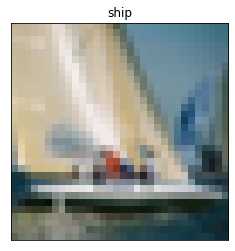

In [6]:
def show_data(image_label):
  image, label = image_label
  image = torch.transpose(torch.transpose(image, 0, 1), 1, 2)
  plt.title(idx2label[label])
  plt.xticks([])
  plt.yticks([])
  _ = plt.imshow(image)

show_data(train_ds[np.random.randint(low=0, high=len(train_dl))])

In [8]:
class Cifar10Classifier(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10Classifier, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_0 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_0, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [9]:
# self-test
x = torch.rand(10, 3, 32, 32)
y = model_0(x)
y.size()

torch.Size([10, 10])

In [10]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_0 = model_0.to(dev)

#### Training

In [11]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [12]:
def train(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [13]:
def validate(model, val_dl, loss_fn):
  model.eval()
  val_losses, val_accs = [], []
  for batch in val_dl:
    images, labels = batch

    images = images.to(dev)
    labels = labels.to(dev)

    with torch.no_grad():
      logits = model(images)
      loss = loss_fn(logits, labels)

    val_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    val_accs.append(accuracy_score(preds, labels))

    # if len(val_losses) > 5:
    #   break

  val_loss = sum(val_losses) / len(val_losses)
  val_acc = sum(val_accs) / len(val_accs)
  return val_loss, val_acc


# # self-test
# val_loss, val_acc = validate(model_0, test_dl, loss_fn)
# val_loss, val_acc

In [14]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_0, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.570, Accuracy: 0.423 | Validation Loss: 1.337, Accuracy: 0.507
Epoch  2 | Train Loss: 1.211, Accuracy: 0.566 | Validation Loss: 1.119, Accuracy: 0.604
Epoch  3 | Train Loss: 1.020, Accuracy: 0.641 | Validation Loss: 1.008, Accuracy: 0.644
Epoch  4 | Train Loss: 0.903, Accuracy: 0.683 | Validation Loss: 0.904, Accuracy: 0.690
Epoch  5 | Train Loss: 0.821, Accuracy: 0.712 | Validation Loss: 0.845, Accuracy: 0.710
Epoch  6 | Train Loss: 0.761, Accuracy: 0.735 | Validation Loss: 0.923, Accuracy: 0.690
Epoch  7 | Train Loss: 0.716, Accuracy: 0.750 | Validation Loss: 0.836, Accuracy: 0.718
Epoch  8 | Train Loss: 0.673, Accuracy: 0.765 | Validation Loss: 0.866, Accuracy: 0.707
Epoch  9 | Train Loss: 0.635, Accuracy: 0.778 | Validation Loss: 0.823, Accuracy: 0.720
Epoch 10 | Train Loss: 0.605, Accuracy: 0.790 | Validation Loss: 0.804, Accuracy: 0.733


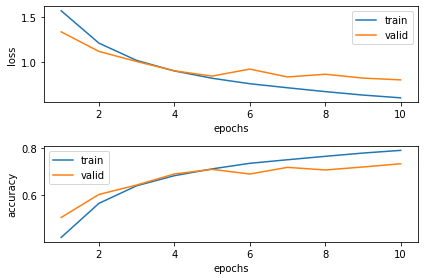

In [15]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
  plt.subplot(2, 1, 1)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_losses, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_losses, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_accs, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_accs, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  plt.tight_layout()
  _ = plt.plot()


plot_training_curves(train_losses, train_accs, val_losses, val_accs)

#### Evaluation

In [16]:
def evaluate(model, test_dl):
  model.eval()
  true_values, pred_values = [], []
  for batch in test_dl:
    images, labels = batch
    images = images.to(dev)

    with torch.no_grad():
      logits = model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.numpy()

    true_values.extend(labels.tolist())
    pred_values.extend(preds.tolist())

  return true_values, pred_values


true_values, pred_values = evaluate(model_0, test_dl)

In [17]:
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.733
--
confusion matrix
[[807  12  53  20   6   6   5  13  49  29]
 [ 23 781  10   6   0   7  10  10  31 122]
 [ 67   2 638  42  75  60  61  38  10   7]
 [ 35   4  71 444  58 231  75  52  18  12]
 [ 25   2  69  44 648  57  54  88  12   1]
 [ 20   2  56  94  35 704  20  55   6   8]
 [ 11   2  52  43  27  20 830   6   7   2]
 [ 10   1  36  15  50  57  10 814   3   4]
 [ 75  12  12  12   6   9   3   6 841  24]
 [ 44  40  11  11   3  13  11  18  27 822]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.72      0.81      0.76      1000
  automobile       0.91      0.78      0.84      1000
        bird       0.63      0.64      0.64      1000
         cat       0.61      0.44      0.51      1000
        deer       0.71      0.65      0.68      1000
         dog       0.60      0.70      0.65      1000
        frog       0.77      0.83      0.80      1000
       horse       0.74      0.81      0.78      1000
        ship      

In [18]:
def write_metrics(true_values, pred_values, experiment_name, metric_filepath):
  fout = open(metric_filepath, "w")
  p, r, f, s = precision_recall_fscore_support(true_values, pred_values, average="micro")
  metrics_dict = {
    "precision": p, "recall": r, "f1-score": f, "support": s
  }
  metrics_dict["name"] = experiment_name
  fout.write(json.dumps(metrics_dict))
  fout.close()


metric_filepath = os.path.join(MODEL_DIR, "model_0.json")
write_metrics(true_values, pred_values, "baseline", metric_filepath)

### Wider Network

In [19]:
model_1 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[512, 10])
summary(model_1, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [20]:
model_1 = model_1.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_1, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_1, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.522, Accuracy: 0.441 | Validation Loss: 1.223, Accuracy: 0.558
Epoch  2 | Train Loss: 1.103, Accuracy: 0.608 | Validation Loss: 0.998, Accuracy: 0.650
Epoch  3 | Train Loss: 0.938, Accuracy: 0.670 | Validation Loss: 0.965, Accuracy: 0.663
Epoch  4 | Train Loss: 0.847, Accuracy: 0.704 | Validation Loss: 0.881, Accuracy: 0.696
Epoch  5 | Train Loss: 0.783, Accuracy: 0.727 | Validation Loss: 0.884, Accuracy: 0.695
Epoch  6 | Train Loss: 0.729, Accuracy: 0.746 | Validation Loss: 0.843, Accuracy: 0.712
Epoch  7 | Train Loss: 0.693, Accuracy: 0.758 | Validation Loss: 0.832, Accuracy: 0.720
Epoch  8 | Train Loss: 0.654, Accuracy: 0.771 | Validation Loss: 0.887, Accuracy: 0.698
Epoch  9 | Train Loss: 0.624, Accuracy: 0.782 | Validation Loss: 0.790, Accuracy: 0.735
Epoch 10 | Train Loss: 0.596, Accuracy: 0.790 | Validation Loss: 0.810, Accuracy: 0.737


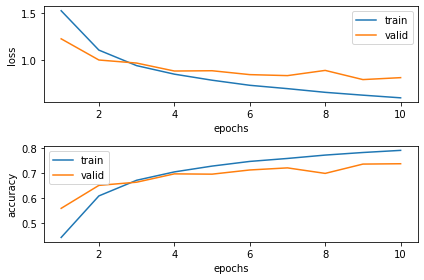

In [21]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [22]:
true_values, pred_values = evaluate(model_1, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.737
--
confusion matrix
[[711  14  71  25  20   7  10  11  98  33]
 [  9 858   7  10   5   6   6   3  23  73]
 [ 53   6 617  41  87  75  69  33  12   7]
 [ 17   5  85 487  81 226  42  34  18   5]
 [ 17   1  69  45 708  43  41  68   7   1]
 [ 11   5  52 100  47 700  26  48   6   5]
 [  5   4  39  51  30  40 810   5  14   2]
 [ 15   0  30  22  54  64   4 805   3   3]
 [ 36  25  10  14   4   6   6   4 872  23]
 [ 31  67  10  11   8  16  10  24  23 800]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.79      0.71      0.75      1000
  automobile       0.87      0.86      0.86      1000
        bird       0.62      0.62      0.62      1000
         cat       0.60      0.49      0.54      1000
        deer       0.68      0.71      0.69      1000
         dog       0.59      0.70      0.64      1000
        frog       0.79      0.81      0.80      1000
       horse       0.78      0.81      0.79      1000
        ship      

In [23]:
metric_filepath = os.path.join(MODEL_DIR, "model_1.json")
write_metrics(true_values, pred_values, "wider_network", metric_filepath)

### Deeper Network

In [24]:
model_2 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[512, 256, 10])
summary(model_2, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [25]:
model_2 = model_2.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_2, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_2, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.511, Accuracy: 0.444 | Validation Loss: 1.226, Accuracy: 0.555
Epoch  2 | Train Loss: 1.123, Accuracy: 0.597 | Validation Loss: 1.025, Accuracy: 0.632
Epoch  3 | Train Loss: 0.958, Accuracy: 0.660 | Validation Loss: 0.942, Accuracy: 0.666
Epoch  4 | Train Loss: 0.861, Accuracy: 0.698 | Validation Loss: 0.946, Accuracy: 0.670
Epoch  5 | Train Loss: 0.796, Accuracy: 0.719 | Validation Loss: 0.855, Accuracy: 0.705
Epoch  6 | Train Loss: 0.745, Accuracy: 0.738 | Validation Loss: 0.892, Accuracy: 0.683
Epoch  7 | Train Loss: 0.708, Accuracy: 0.751 | Validation Loss: 0.861, Accuracy: 0.701
Epoch  8 | Train Loss: 0.679, Accuracy: 0.762 | Validation Loss: 0.836, Accuracy: 0.712
Epoch  9 | Train Loss: 0.649, Accuracy: 0.771 | Validation Loss: 0.857, Accuracy: 0.711
Epoch 10 | Train Loss: 0.625, Accuracy: 0.781 | Validation Loss: 0.874, Accuracy: 0.708


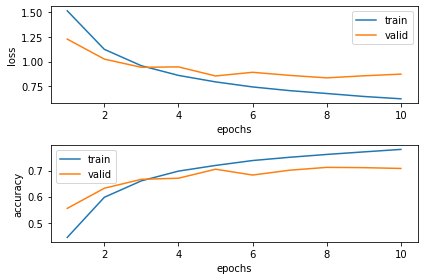

In [26]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [27]:
true_values, pred_values = evaluate(model_2, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.708
--
confusion matrix
[[817  13  11  10  25   2   6   9  64  43]
 [ 18 785   5   2   2   2  10   3  37 136]
 [117   3 493  21 163  36 104  28  19  16]
 [ 50   8  58 381 135 146 137  38  34  13]
 [ 28   5  33  16 773  17  76  41  11   0]
 [ 29   3  62 103  94 541  65  66  25  12]
 [ 19   4  31  16  40   7 850   7  22   4]
 [ 33   3  27  24 114  23  19 738   4  15]
 [ 74  21   2   1   9   1   7   3 860  22]
 [ 40  54   3   4  12   3   7  10  28 839]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.67      0.82      0.73      1000
  automobile       0.87      0.79      0.83      1000
        bird       0.68      0.49      0.57      1000
         cat       0.66      0.38      0.48      1000
        deer       0.57      0.77      0.65      1000
         dog       0.70      0.54      0.61      1000
        frog       0.66      0.85      0.75      1000
       horse       0.78      0.74      0.76      1000
        ship      

In [28]:
metric_filepath = os.path.join(MODEL_DIR, "model_2.json")
write_metrics(true_values, pred_values, "deeper_network", metric_filepath)

### Add Batch Normalization (before ReLU)

There seems to be some controversy about where to put the BatchNorm in the model. According to Andrew Ng, it should be put before the non-linearity but according to Francois Chollet, the authors of the BatchNorm paper put this after the non-linerity. See [Stack Overflow discussion](https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns#:~:text=Andrew%20Ng%20says%20that%20batch,BN%20after%20the%20activation%20layer.).

We will try both approaches to compare.

In [29]:
class Cifar10ClassifierBNR(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierBNR, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.ReLU(),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_3 = Cifar10ClassifierBNR(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_3, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
        Dropout2d-14             [-1, 6

In [30]:
model_3 = model_3.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_3, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_3, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.225, Accuracy: 0.560 | Validation Loss: 1.026, Accuracy: 0.643
Epoch  2 | Train Loss: 0.865, Accuracy: 0.697 | Validation Loss: 1.029, Accuracy: 0.640
Epoch  3 | Train Loss: 0.750, Accuracy: 0.738 | Validation Loss: 0.830, Accuracy: 0.712
Epoch  4 | Train Loss: 0.663, Accuracy: 0.769 | Validation Loss: 0.825, Accuracy: 0.722
Epoch  5 | Train Loss: 0.606, Accuracy: 0.788 | Validation Loss: 0.769, Accuracy: 0.742
Epoch  6 | Train Loss: 0.554, Accuracy: 0.805 | Validation Loss: 0.879, Accuracy: 0.713
Epoch  7 | Train Loss: 0.507, Accuracy: 0.823 | Validation Loss: 0.756, Accuracy: 0.750
Epoch  8 | Train Loss: 0.465, Accuracy: 0.838 | Validation Loss: 0.788, Accuracy: 0.743
Epoch  9 | Train Loss: 0.430, Accuracy: 0.849 | Validation Loss: 0.841, Accuracy: 0.736
Epoch 10 | Train Loss: 0.395, Accuracy: 0.861 | Validation Loss: 0.924, Accuracy: 0.717


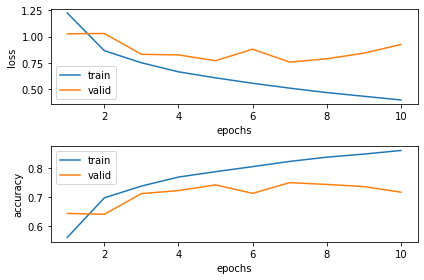

In [31]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [32]:
true_values, pred_values = evaluate(model_3, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.716
--
confusion matrix
[[778  24  86  15   3  17  29   3  20  25]
 [ 10 900   4   3   0  10  20   2   9  42]
 [ 47   4 705  31  10  87 106   5   1   4]
 [ 13   9  71 453  16 264 157   3   6   8]
 [ 17   3 176  58 440  67 215  20   1   3]
 [  9   3  37  89  10 763  72  13   1   3]
 [  2   3  27  16   0  23 927   0   1   1]
 [ 18   9  67  43  31 137  39 641   1  14]
 [116  36  26   7   1  10  35   0 755  14]
 [ 40  93   8  11   1  12  20   1  12 802]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.74      0.78      0.76      1000
  automobile       0.83      0.90      0.86      1000
        bird       0.58      0.70      0.64      1000
         cat       0.62      0.45      0.52      1000
        deer       0.86      0.44      0.58      1000
         dog       0.55      0.76      0.64      1000
        frog       0.57      0.93      0.71      1000
       horse       0.93      0.64      0.76      1000
        ship      

In [33]:
metric_filepath = os.path.join(MODEL_DIR, "model_3.json")
write_metrics(true_values, pred_values, "batchnorm_before_relu", metric_filepath)

### Add Batch Normalization (after ReLU)

In [34]:
class Cifar10ClassifierRBN(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierRBN, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_4 = Cifar10ClassifierRBN(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_4, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
             ReLU-12             [-1, 64, 8, 8]               0
      BatchNorm2d-13             [-1, 64, 8, 8]             128
        Dropout2d-14             [-1, 6

In [35]:
model_4 = model_4.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_4, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_4, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.162, Accuracy: 0.588 | Validation Loss: 0.921, Accuracy: 0.676
Epoch  2 | Train Loss: 0.815, Accuracy: 0.714 | Validation Loss: 0.862, Accuracy: 0.696
Epoch  3 | Train Loss: 0.694, Accuracy: 0.757 | Validation Loss: 0.802, Accuracy: 0.725
Epoch  4 | Train Loss: 0.614, Accuracy: 0.784 | Validation Loss: 0.754, Accuracy: 0.746
Epoch  5 | Train Loss: 0.544, Accuracy: 0.809 | Validation Loss: 0.829, Accuracy: 0.729
Epoch  6 | Train Loss: 0.492, Accuracy: 0.827 | Validation Loss: 0.791, Accuracy: 0.742
Epoch  7 | Train Loss: 0.451, Accuracy: 0.840 | Validation Loss: 0.847, Accuracy: 0.726
Epoch  8 | Train Loss: 0.410, Accuracy: 0.854 | Validation Loss: 0.834, Accuracy: 0.737
Epoch  9 | Train Loss: 0.377, Accuracy: 0.867 | Validation Loss: 0.899, Accuracy: 0.736
Epoch 10 | Train Loss: 0.339, Accuracy: 0.880 | Validation Loss: 0.851, Accuracy: 0.752


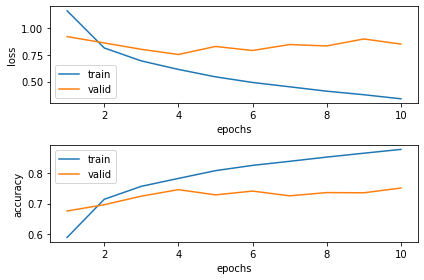

In [36]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [37]:
true_values, pred_values = evaluate(model_4, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.751
--
confusion matrix
[[789  25  35  23   7  11   9   6  46  49]
 [  7 887   1   4   2   0   5   0  13  81]
 [ 61   7 668  35  44  92  56  17   9  11]
 [ 21  17  66 526  53 191  76  15  14  21]
 [ 20   9  85  43 650  65  79  28  15   6]
 [ 14  10  38 100  35 716  37  36   7   7]
 [  4  10  46  48  22  18 840   2   4   6]
 [ 21   9  32  35  62  73  11 726   8  23]
 [ 52  35  11   5   6   3   6   3 849  30]
 [ 24  66   5   4   3   8   5   8  14 863]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.78      0.79      0.78      1000
  automobile       0.83      0.89      0.85      1000
        bird       0.68      0.67      0.67      1000
         cat       0.64      0.53      0.58      1000
        deer       0.74      0.65      0.69      1000
         dog       0.61      0.72      0.66      1000
        frog       0.75      0.84      0.79      1000
       horse       0.86      0.73      0.79      1000
        ship      

In [38]:
metric_filepath = os.path.join(MODEL_DIR, "model_4.json")
write_metrics(true_values, pred_values, "batchnorm_after_relu", metric_filepath)

### Residual Connection

According to [Residual Networks: Implementing ResNets in Pytorch](https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278), a basic ResNet block is composed of two layers of 3x3 conv/batchnorm/relu. Our original model has 3 layers, so we will convert the last two convolution layers into a ResNet block. The shortcut (the "identity" path in the figure below) will pass the input through a 1x1 convolution so the addition `F(x) + x` can be done.

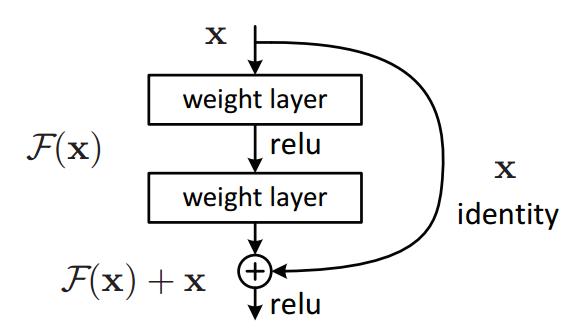

Note that this is just one of the configurations possible with ResNet, other configurations are possible as indicated in [Residual Networks: Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

In [39]:
class Cifar10ClassifierRes(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierRes, self).__init__()
    # convolution layers
    conv_layers, shortcuts, poolings = [], [], []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        # batchnorm before relu gives better results
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.ReLU(),
        nn.Conv2d(conv_block_sizes[cid], conv_block_sizes[cid],
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.Dropout2d(p=spatial_dropout)))
      shortcuts.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1], 
                  conv_block_sizes[cid], 
                  kernel_size=(1, 1))))
      poolings.append(nn.MaxPool2d(kernel_size=(2, 2)))

    self.conv_blocks = nn.ModuleList(conv_layers)
    self.shortcut_paths = nn.ModuleList(shortcuts)
    self.pool_ops = nn.ModuleList(poolings)

    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block, shortcut_path, pool_op in zip(
        self.conv_blocks, self.shortcut_paths, self.pool_ops):
      x = conv_block(x) + shortcut_path(x)
      x = F.relu(x)
      x = pool_op(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_5 = Cifar10ClassifierRes(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_5, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         Dropout2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             128
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        Dropout2d-14           [-1, 64,

In [40]:
model_5 = model_5.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_5, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_5, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.126, Accuracy: 0.597 | Validation Loss: 1.017, Accuracy: 0.651
Epoch  2 | Train Loss: 0.701, Accuracy: 0.753 | Validation Loss: 0.733, Accuracy: 0.751
Epoch  3 | Train Loss: 0.559, Accuracy: 0.804 | Validation Loss: 0.672, Accuracy: 0.764
Epoch  4 | Train Loss: 0.467, Accuracy: 0.837 | Validation Loss: 0.638, Accuracy: 0.788
Epoch  5 | Train Loss: 0.400, Accuracy: 0.860 | Validation Loss: 0.649, Accuracy: 0.780
Epoch  6 | Train Loss: 0.333, Accuracy: 0.883 | Validation Loss: 0.630, Accuracy: 0.794
Epoch  7 | Train Loss: 0.283, Accuracy: 0.900 | Validation Loss: 0.657, Accuracy: 0.802
Epoch  8 | Train Loss: 0.242, Accuracy: 0.913 | Validation Loss: 0.678, Accuracy: 0.807
Epoch  9 | Train Loss: 0.200, Accuracy: 0.927 | Validation Loss: 0.679, Accuracy: 0.807
Epoch 10 | Train Loss: 0.174, Accuracy: 0.938 | Validation Loss: 0.766, Accuracy: 0.807


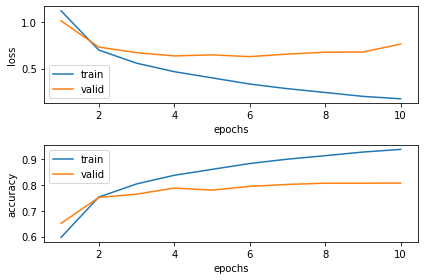

In [41]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [42]:
true_values, pred_values = evaluate(model_5, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.807
--
confusion matrix
[[877  16  29   7   6   2   3  10  39  11]
 [ 14 944   1   4   1   0   3   0   7  26]
 [ 82   4 714  47  43  46  32  23   6   3]
 [ 30   5  53 653  33 141  34  28  10  13]
 [ 26   4  83  42 730  39  27  43   5   1]
 [  6   8  23 100  35 779   7  33   4   5]
 [ 14  11  55  68   9  21 803   4   9   6]
 [ 18   2  19  24  33  52   1 838   2  11]
 [ 56  31   2   3   0   2   2   0 888  16]
 [ 34  85   3   3   0   2   0   8  19 846]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.76      0.88      0.81      1000
  automobile       0.85      0.94      0.89      1000
        bird       0.73      0.71      0.72      1000
         cat       0.69      0.65      0.67      1000
        deer       0.82      0.73      0.77      1000
         dog       0.72      0.78      0.75      1000
        frog       0.88      0.80      0.84      1000
       horse       0.85      0.84      0.84      1000
        ship      

In [43]:
metric_filepath = os.path.join(MODEL_DIR, "model_5.json")
write_metrics(true_values, pred_values, "residual_conn", metric_filepath)

### Gradient Clipping

More popular in RNNs, and wasn't actually mentioned in the lectures, but I learned about it in passing and was curious to see if it might have an effect on CNNs.

This is achieved in the training loop by clipping the gradients (between `loss.backward()` and `optimizer.step()`.

In [44]:
model_6 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_6, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [47]:
def train_with_grad_clipping(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# dev = "cpu"
# train_loss, train_acc = train(model_6, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [48]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_6 = model_6.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train_with_grad_clipping(model_6, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_6, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.587, Accuracy: 0.419 | Validation Loss: 1.372, Accuracy: 0.506
Epoch  2 | Train Loss: 1.236, Accuracy: 0.560 | Validation Loss: 1.168, Accuracy: 0.584
Epoch  3 | Train Loss: 1.050, Accuracy: 0.628 | Validation Loss: 1.107, Accuracy: 0.615
Epoch  4 | Train Loss: 0.937, Accuracy: 0.670 | Validation Loss: 0.960, Accuracy: 0.667
Epoch  5 | Train Loss: 0.859, Accuracy: 0.699 | Validation Loss: 0.991, Accuracy: 0.657
Epoch  6 | Train Loss: 0.797, Accuracy: 0.720 | Validation Loss: 0.860, Accuracy: 0.699
Epoch  7 | Train Loss: 0.746, Accuracy: 0.741 | Validation Loss: 0.846, Accuracy: 0.713
Epoch  8 | Train Loss: 0.693, Accuracy: 0.759 | Validation Loss: 0.825, Accuracy: 0.723
Epoch  9 | Train Loss: 0.661, Accuracy: 0.768 | Validation Loss: 0.825, Accuracy: 0.721
Epoch 10 | Train Loss: 0.626, Accuracy: 0.781 | Validation Loss: 0.824, Accuracy: 0.723


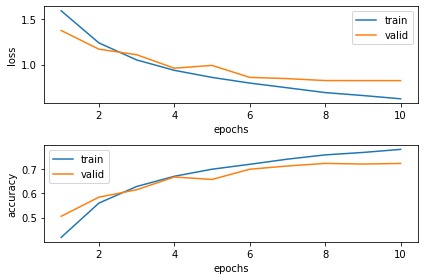

In [49]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [50]:
true_values, pred_values = evaluate(model_6, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.723
--
confusion matrix
[[740   9 120  31  21   7   5   5  38  24]
 [ 38 811  13  16   5   5   7   1  34  70]
 [ 48   6 683  76  59  52  42  22   5   7]
 [ 20   6  90 552  55 183  52  25   8   9]
 [ 17   1 130  61 667  26  33  56   8   1]
 [ 18   4  70 156  25 666  18  37   4   2]
 [  5   1  82  65  33  20 784   5   5   0]
 [ 16   3  52  60  56  61   4 741   1   6]
 [ 86  20  31  24   5  12   7   2 806   7]
 [ 61  56  10  31   4  12  12  10  26 778]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.71      0.74      0.72      1000
  automobile       0.88      0.81      0.85      1000
        bird       0.53      0.68      0.60      1000
         cat       0.51      0.55      0.53      1000
        deer       0.72      0.67      0.69      1000
         dog       0.64      0.67      0.65      1000
        frog       0.81      0.78      0.80      1000
       horse       0.82      0.74      0.78      1000
        ship      

In [51]:
metric_filepath = os.path.join(MODEL_DIR, "model_6.json")
write_metrics(true_values, pred_values, "gradient_clipping", metric_filepath)

### Increase Batch Size

We will increase the batch size from 64 to 128. This will require us to reinstantiate our data loaders.

In [52]:
BATCH_SIZE = 128

train_dl_128 = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl_128 = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl_128), len(test_dl_128)

(391, 79)

In [53]:
model_7 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64, 10])
summary(model_7, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [54]:
model_7 = model_7.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_7.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_7, train_dl_128, loss_fn, optimizer)
  val_loss, val_acc = validate(model_7, test_dl_128, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.668, Accuracy: 0.390 | Validation Loss: 1.400, Accuracy: 0.491
Epoch  2 | Train Loss: 1.312, Accuracy: 0.526 | Validation Loss: 1.242, Accuracy: 0.554
Epoch  3 | Train Loss: 1.128, Accuracy: 0.597 | Validation Loss: 1.042, Accuracy: 0.633
Epoch  4 | Train Loss: 1.002, Accuracy: 0.646 | Validation Loss: 1.030, Accuracy: 0.634
Epoch  5 | Train Loss: 0.918, Accuracy: 0.677 | Validation Loss: 0.922, Accuracy: 0.679
Epoch  6 | Train Loss: 0.847, Accuracy: 0.703 | Validation Loss: 0.906, Accuracy: 0.688
Epoch  7 | Train Loss: 0.795, Accuracy: 0.720 | Validation Loss: 0.873, Accuracy: 0.701
Epoch  8 | Train Loss: 0.750, Accuracy: 0.735 | Validation Loss: 0.841, Accuracy: 0.711
Epoch  9 | Train Loss: 0.702, Accuracy: 0.755 | Validation Loss: 0.815, Accuracy: 0.719
Epoch 10 | Train Loss: 0.674, Accuracy: 0.765 | Validation Loss: 0.805, Accuracy: 0.724


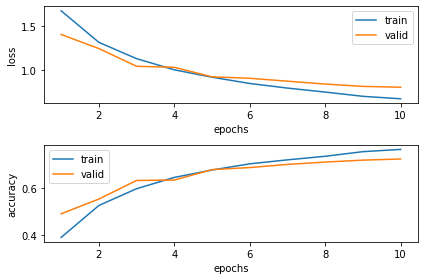

In [55]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [56]:
true_values, pred_values = evaluate(model_7, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.724
--
confusion matrix
[[751  15  36  13  15   2  12   9  99  48]
 [ 15 810   3   5   6   3  11   9  27 111]
 [ 94   8 533  43 115  61  82  34  16  14]
 [ 27  11  59 468  85 175  81  38  34  22]
 [ 22   2  48  39 727  24  56  64  14   4]
 [ 19   1  40 123  72 638  27  51  17  12]
 [  4   2  31  42  48  19 834   5  10   5]
 [ 15   3  35  28  84  60  12 735   5  23]
 [ 35  21   9   5   3   5   7   3 887  25]
 [ 26  54   5  13   1   3   8   8  28 854]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.75      0.75      0.75      1000
  automobile       0.87      0.81      0.84      1000
        bird       0.67      0.53      0.59      1000
         cat       0.60      0.47      0.53      1000
        deer       0.63      0.73      0.67      1000
         dog       0.64      0.64      0.64      1000
        frog       0.74      0.83      0.78      1000
       horse       0.77      0.73      0.75      1000
        ship      

In [57]:
metric_filepath = os.path.join(MODEL_DIR, "model_7.json")
write_metrics(true_values, pred_values, "inc_batch_size", metric_filepath)

## Model Comparison

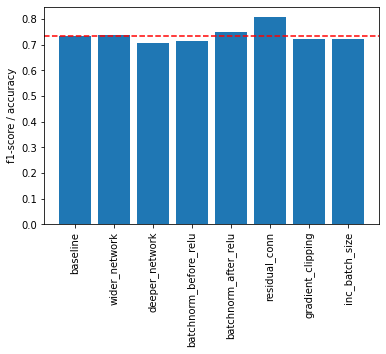

In [58]:
json_files = []
for f in os.listdir(MODEL_DIR):
  if f.endswith(".json"):
    json_files.append(f)

xs, ps, rs, fs = [], [], [], []
for json_file in sorted(json_files):
  with open(os.path.join(MODEL_DIR, json_file), "r") as f:
    metrics_dict = json.loads(f.read())
    xs.append(metrics_dict["name"])
    ps.append(metrics_dict["precision"])
    rs.append(metrics_dict["recall"])
    fs.append(metrics_dict["f1-score"])

plt.bar(np.arange(len(fs)), fs)
plt.ylabel("f1-score / accuracy")
plt.xticks(np.arange(len(fs)), xs, rotation="90")
plt.axhline(fs[0], 0, len(fs), color="r", linestyle="--")
_ = plt.show()

In [59]:
fidx_max, fidx_min = np.argmax(fs), np.argmin(fs)
print("Best results using {:s}: F1-score : {:.3f}".format(
    xs[fidx_max], fs[fidx_max]))
print("Worst results using {:s}: F1-score: {:.3f}".format(
    xs[fidx_min], fs[fidx_min]))

Best results using residual_conn: F1-score : 0.807
Worst results using deeper_network: F1-score: 0.708
